


# <center> Classification KNN</center>
*Goubet Victor<br>
Graff Thomas*<br>
TD D

# Partie I


### Prepatation des données
On commence par importer les librairies necessaires :

In [2]:
import pandas as pd
from sklearn import model_selection
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

On importe les données :

In [3]:
data= pd.read_csv('data.csv',sep=';')

Ici on stock dans le vecteur X les colonnes correspondant aux classe et dans 
Y celles correspondant aux etiquettes

In [4]:
entete=data.columns[:-1]
X=data[entete].values
Y=data[data.columns[-1]].to_numpy()
labels_Class=np.unique(Y)

On utilise le module Sklearn pour séparer nos donner en un jeux d'entrainement et un autre de test. <br>
La separation est plus efficace car il procéde à un mélange alétoire avant de séparer les données

In [5]:
X_train, X_test, Y_train, Y_test = model_selection.train_test_split(X, Y,test_size=0.2,random_state=4871)
#On fixe le random state afin d'avoir toujours la même distribution aléatoire
print(X_train.shape)

(2301, 4)


### Definition du Model

In [6]:
class KNN:
    
    def __init__(self,k=1):
        self.k=k
        
    def Train(self,X_train,Y_train):
        self.X_train=X_train
        self.Y_train=Y_train
        
    def Distance(self,ptTest,ptTrain):
        #On commence par définir une fonction de calcul de distance. Ici on choisit la distance euclidienne
        distance=0
        for k in range(len(ptTrain)):
            distance+=(ptTrain[k]-ptTest[k])**2
        return np.sqrt(distance)
    
    
    def GetLabel(self,instance):
        #On definit la fonction GetLabel permettant de prédir l'étiquette d'une instance
        distances=[self.Distance(instance,x) for x in self.X_train ]
        indexes=np.argsort(distances)[:self.k]
        Top_Neighbours=np.array([self.Y_train[i] for i in indexes])

        return max(labels_Class,key=lambda x:np.sum(Top_Neighbours==x))

    def GetLabels(self,X):
        #On récupére ici le label de chaque instance
        labels=[self.GetLabel(x) for x in X]
        return np.array(labels)
    
    def Precision(self,X_test,Y_test,MC):
        #On compare nos label estimés aux réel labels et on en déduit une precision
        labels=self.GetLabels(X_test)
        precision=np.sum(labels==Y_test)/len(labels)*100
        
        if MC:
            print("Matrice de confusion :")
            print(confusion_matrix(Y_test,labels))
        
        return precision

### Test du model

On test notre fonction avec le resultat labels utilisant k=5 <br> On affiche le pourcentage de precision et la matrice de confusion

In [7]:
model=KNN(5)
model.Train(X_train,Y_train)
model.Precision(X_test,Y_test,True)

Matrice de confusion :
[[274   0   0   0   0   0   1   0   1   0]
 [  0  60   0   2   2   0   1   0   1   0]
 [  3   0  23   7   3   1   1   0   1   0]
 [  0   3   1  24   6   3   0   0   3   0]
 [  5   0   1   0  74   3   1   0   0   0]
 [  0   2   0   2   5  12   0   0   4   0]
 [  0   0   1   1   4   0   3   1   0   0]
 [  0   1   0   1   4   0   0   5   0   1]
 [  3   0   1   1   0   0   0   0  14   0]
 [  0   0   0   0   0   1   0   0   0   4]]


85.59027777777779

### Optimisation du model

Maintenant que notre modèle est construit et qu'il nous fournis des resultats acceptable, nous pouvons essayer de régler le paramètre k afin d'augmenter notre score.
Pour cela on va séparer nos données non pas en deux mais en 3 sets. Un pour l'entrainement, un pour la validation (optimisation de k ) et un dernier pour le test final.

Cependant, plusieurs découpages de nos donnèes sont possibles pour choisir notre set de validation. On va donc utiliser la méthode de **cross validation** qui permet d'explorer tout les découpages possibles pour notre set et de retourner à chaque fois son score.<br>
Ici on va utilise le découpage des **KFolds**

In [8]:
def CrossValidation(k,X_train,Y_train,nFolds=5):
    scoresValidation=[]
    
    model=KNN(k)
    X_Splits=np.array_split(X_train,nFolds)
    Y_Splits=np.array_split(Y_train,nFolds)

    for i in range(nFolds):
        print("\nCalcul du fold n°(",i+1,"/",nFolds,")..")
        X_validation=X_Splits[i]
        Y_validation=Y_Splits[i]
        X_newTrain=np.concatenate(np.delete(X_Splits,i))
        Y_newTrain=np.concatenate(np.delete(Y_Splits,i))
        
        model.Train(X_newTrain,Y_newTrain)
        scoresValidation.append(model.Precision(X_validation,Y_validation,False))
        
    return np.array(scoresValidation)
        
        

On peut maintenant tester notre methode pour k=5 et 5 folds

In [9]:
scoresValidation=CrossValidation(5,X_train,Y_train)
print("\nScore sur le set de validation pour chaque fold :\n",scoresValidation)
print("\nMoyenne des scores:",scoresValidation.mean())


Calcul du fold n°( 1 / 5 )..

Calcul du fold n°( 2 / 5 )..

Calcul du fold n°( 3 / 5 )..

Calcul du fold n°( 4 / 5 )..

Calcul du fold n°( 5 / 5 )..

Score sur le set de validation pour chaque fold :
 [88.06941432 84.13043478 86.30434783 88.04347826 85.        ]

Moyenne des scores: 86.3095350372536


Nous sommes maintenant prêt à tester pour differents valeures de k <br> On va tracer le score sur le set de validation en fonction de k. 

In [13]:

def Optimise(listeK,X_train,Y_train):
    scoresValidation=[]
    
    for k in listeK:
        print("===========================Test k=",k,"==================================")

        accuracy=CrossValidation(k,X_train,Y_train,5).mean()
        scoresValidation.append(accuracy)
        print("\n→ Accuracy =",accuracy)
    return scoresValidation
    

In [14]:
listeK=range(1,15)
scoresValidation=Optimise(listeK,X_train,Y_train)

===========================Test k= 1 ==================================

Calcul du fold n°( 1 / 5 )..

Calcul du fold n°( 2 / 5 )..

Calcul du fold n°( 3 / 5 )..

Calcul du fold n°( 4 / 5 )..

Calcul du fold n°( 5 / 5 )..

→ Accuracy = 84.52824672262567
===========================Test k= 2 ==================================

Calcul du fold n°( 1 / 5 )..

Calcul du fold n°( 2 / 5 )..

Calcul du fold n°( 3 / 5 )..

Calcul du fold n°( 4 / 5 )..

Calcul du fold n°( 5 / 5 )..

→ Accuracy = 84.48420258417428
===========================Test k= 3 ==================================

Calcul du fold n°( 1 / 5 )..

Calcul du fold n°( 2 / 5 )..

Calcul du fold n°( 3 / 5 )..

Calcul du fold n°( 4 / 5 )..

Calcul du fold n°( 5 / 5 )..

→ Accuracy = 85.52730359332263
===========================Test k= 4 ==================================

Calcul du fold n°( 1 / 5 )..

Calcul du fold n°( 2 / 5 )..

Calcul du fold n°( 3 / 5 )..

Calcul du fold n°( 4 / 5 )..

Calcul du fold n°( 5 / 5 )..

→ Accuracy = 86

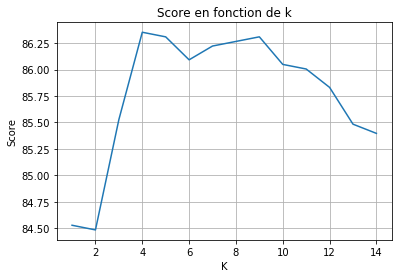

In [15]:
plt.plot(listeK,scoresValidation)
plt.title("Score en fonction de k")
plt.ylabel("Score")
plt.xlabel("K")
plt.grid()

On peut voir ici que l'on obtient des scores haut pour k=4 ou k=9. Cependant un k faible peut être synonime de suraprentissage. On choisit donc k=9.
### Test final

In [30]:
model=KNN(9)
model.Train(X_train,Y_train)
model.Precision(X_test,Y_test,True)

Matrice de confusion :
[[274   0   0   0   0   0   1   0   1   0]
 [  0  60   0   0   3   1   1   0   1   0]
 [  4   0  23   7   3   1   0   0   1   0]
 [  0   3   1  26   4   3   1   0   2   0]
 [  4   0   2   0  73   4   1   0   0   0]
 [  0   2   0   2   5  11   0   0   5   0]
 [  0   0   2   1   3   0   3   1   0   0]
 [  0   1   0   0   5   0   0   4   0   2]
 [  3   0   0   3   0   0   1   0  12   0]
 [  0   0   0   0   0   1   0   0   0   4]]


85.06944444444444

On obtient finalement un socre de **85.07**. On voit que l'on fait principalement des erreures su la colonne I.

### Ameliorations

Une première amélioration serait d'optimiser les calculs afins qu'ils soient plus rapides.<br>
Une deuxième amélioration non nègligeable serait d'optimiser un deuxième hyper paramètre qui est le calcul de la distance en utilisant par exemple la distance manathane. Cependant cela reviendrait à chercher la solution dans une grille (distance en ligne et k en colonne) soit environs 3x20 possibilitées (3 types de distance et on test 15 k) ce qui prendrait enormement de temps avec une version non optimisée.<br> On revient donc à la première améliroation..

## Comparaison avec le model de Sklearn

### Optimisation de k

In [19]:
from sklearn.model_selection  import validation_curve
from sklearn.neighbors import KNeighborsClassifier

On utilise ici le model fournit par le package et l'optimisation de k par cross validation

In [20]:
model=KNeighborsClassifier()

ScoreTrain,ScoreValidation=validation_curve(model,X_train,Y_train,'n_neighbors',listeK,cv=5)

ScoreValidation_Mean=ScoreValidation.mean(axis=1)
ScoreTrain_Mean=ScoreTrain.mean(axis=1)

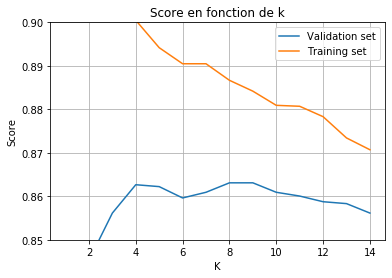

In [21]:
plt.plot(listeK,ScoreValidation_Mean,label='Validation set')
plt.plot(listeK,ScoreTrain_Mean,label='Training set')
plt.legend()
plt.title("Score en fonction de k")
plt.ylabel("Score")
plt.xlabel("K")
plt.ylim(0.85,0.9)
plt.grid()
plt.show()

- On a également tracé ici la courbe de score pour le training set. Cela nous permet de reperer les zones de suraprentissages (typiquement pour k< 4-5 ici).
- On obtient donc ici k=8 ou 9



### GridSearch

In [27]:
from sklearn.model_selection import GridSearchCV

In [28]:
parametres={'n_neighbors':listeK,'metric':['euclidean','manhattan','minkowski']}

grid=GridSearchCV(KNeighborsClassifier(),parametres,cv=5)
grid.fit(X_train,Y_train)
print(grid.best_params_)

{'metric': 'euclidean', 'n_neighbors': 9}


On s'apercoit qu'ici la distance euclidienne est la meilleure et que k=9 est la meilleure option. On trouve donc un k du même ordre de grandeure que plus haut

In [29]:
model=grid.best_estimator_
model.score(X_test,Y_test)

0.8506944444444444

On obtient avec ce model une precision de **85.07** sur le set de test qui est égal au score trouvé plus haut.

# Partie II
Nous avons maintenant un deuxième dataset à diposition. Nous avons choisit d'utiliser ce dataset afin d'agrandir nos données d'aprentissage. En effet un plus grand nombre de données d'entrainement améliorera le score de notre model (on peut d'ailleurs le voir sur les learning curve avec sklearn). <br> Dans un premier temps nous allons tester notre model sur ces datas voir si tout se passe bien, puis, nous fusionnerons les deux datasets et nous l'entrainerons avec ces nouvelles données.

### Test sur le nouveau dataset

*on prépare nos donnèes*

In [31]:
data2= pd.read_csv('preTest.csv',sep=';')
entete2=data2.columns[:-1]

X2=data2[entete2].values
Y2=data2[data2.columns[-1]].to_numpy()

On regarde le score pour notre nouveau dataSet

In [34]:
model2=KNN(9)
model2.Train(X_train,Y_train)
model2.Precision(X2,Y2,True)

Matrice de confusion :
[[1364    0    0    1    2    0    3    0    4    0]
 [   0  241    0    6    8    5    3    0    3    0]
 [  10    5  137   13   11    4    0    0    5    0]
 [   0    7    3  184   11    8    2    1   10    0]
 [  23    1   13    7  400    4    2    1    5    0]
 [   0    9    4   16   15   64    1    0   15    1]
 [   3    2    5    2   13    1   17    3    1    2]
 [   0    5    1    1   14    0    0   24    1    3]
 [  15    7    3   13    3    8    1    2   70    0]
 [   0    2    0    0    2    1    0    0    0   20]]


87.62599930483142

### Fusion des dataSets

In [46]:
X3=np.concatenate([X,X2])
Y3=np.concatenate([Y,Y2])

X_train3, X_test3, Y_train3, Y_test3 = model_selection.train_test_split(X3, Y3,test_size=0.2,random_state=4871)

On optimise de nouveau le model

In [48]:
scoresValidation3=Optimise(listeK,X_train3,Y_train3)

===========================Test k= 1 ==================================

Calcul du fold n°( 1 / 5 )..

Calcul du fold n°( 2 / 5 )..

Calcul du fold n°( 3 / 5 )..

Calcul du fold n°( 4 / 5 )..

Calcul du fold n°( 5 / 5 )..

→ Accuracy = 94.19912193740264
===========================Test k= 2 ==================================

Calcul du fold n°( 1 / 5 )..

Calcul du fold n°( 2 / 5 )..

Calcul du fold n°( 3 / 5 )..

Calcul du fold n°( 4 / 5 )..

Calcul du fold n°( 5 / 5 )..

→ Accuracy = 89.35457678326961
===========================Test k= 3 ==================================

Calcul du fold n°( 1 / 5 )..

Calcul du fold n°( 2 / 5 )..

Calcul du fold n°( 3 / 5 )..

Calcul du fold n°( 4 / 5 )..

Calcul du fold n°( 5 / 5 )..

→ Accuracy = 86.76931973752536
===========================Test k= 4 ==================================

Calcul du fold n°( 1 / 5 )..

Calcul du fold n°( 2 / 5 )..

Calcul du fold n°( 3 / 5 )..

Calcul du fold n°( 4 / 5 )..

Calcul du fold n°( 5 / 5 )..

→ Accuracy = 87

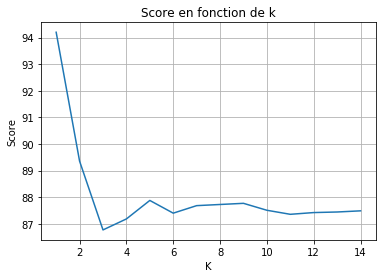

In [49]:
plt.plot(listeK,scoresValidation3)
plt.title("Score en fonction de k")
plt.ylabel("Score")
plt.xlabel("K")
plt.grid()

On test notre model sur le nouveau set de test

In [ ]:
model3=KNN(8)
model3.fit(X_train3,Y_train3)
model3.Precision(X_test3,Y_test3)

# Partie III
Nous allons maintenant tester notre model sur un dataset inconnu dont on ne connait pas les etiquettes.<br>
On va commencer par importer les donnèes: 

In [ ]:
datafinal= pd.read_csv('finalTest.csv',sep=';')
entetefinal=datafinal.columns
Xfinal=datafinal[entetefinal].values

### Enregistrement des labels
On enregistre les labels dans un fichier texte

In [17]:
def Save(labels):
    with open("GOUBET_GRAFF.txt",'w') as f:
        for label in labels:
            f.write(label+"\n")

In [18]:
labels=model3.GetLabels(Xfinal)
Save(labels)